Before launching jupyter and this notebook, type in terminal: 

``source activate nbodykit-env``

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from nbodykit.lab import *
from nbodykit import setup_logging, style
from nbodykit.algorithms.fftpower import project_to_basis

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
plt.style.use(style.notebook)

In [3]:
setup_logging() # turn on logging to screen

# FKP shot noise

Let us compute the shot noise of the FKP estimator. 

### Getting BOSS catalogs

In [5]:
def print_download_progress(count, block_size, total_size):
    import sys
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def download_data(download_dir):
    """
    Download the FITS data needed for this notebook to the specified directory.
    
    Parameters
    ----------
    download_dir : str
        the data will be downloaded to this directory
    """
    from six.moves import urllib
    import shutil
    import gzip
    
    urls = ['https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_North.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random1_DR12v5_CMASSLOWZTOT_North.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random1_DR12v5_CMASSLOWZTOT_South.fits.gz',]
    filenames = ['random0_DR12v5_CMASSLOWZTOT_North.fits', 
                 'random0_DR12v5_CMASSLOWZTOT_South.fits',
                 'random1_DR12v5_CMASSLOWZTOT_North.fits', 
                 'random1_DR12v5_CMASSLOWZTOT_South.fits',]
    
    # download both files
    for i, url in enumerate(urls):
        
        # the download path
        filename = url.split('/')[-1]
        file_path = os.path.join(download_dir, filename)
        final_path = os.path.join(download_dir, filenames[i])
        
        # do not re-download
        if not os.path.exists(final_path):
            print("Downloading %s" % url)
            
            # Check if the download directory exists, otherwise create it.
            if not os.path.exists(download_dir):
                os.makedirs(download_dir)

            # Download the file from the internet.
            file_path, _ = urllib.request.urlretrieve(url=url,
                                                      filename=file_path,
                                                      reporthook=print_download_progress)

            print()
            print("Download finished. Extracting files.")

            # unzip the file
            with gzip.open(file_path, 'rb') as f_in, open(final_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            os.remove(file_path)
            print("Done.")
        else:
            print("Data has already been downloaded.")

In [7]:
# download the data to the current directory
download_dir = os.path.join(os.path.expanduser("~"), "Documents", "EFTofLSS", "BOSS_measurements", "catalogs")
download_data(download_dir)

Data has already been downloaded.
Data has already been downloaded.
Data has already been downloaded.
Data has already been downloaded.


Here we use two randoms catalogs.

### Selecting the skycut

In [8]:
red, sky = 'lowz', 'South'
if red == 'lowz': zmin, zmax = 0.20, 0.43
elif red == 'cmass': zmin, zmax = 0.43, 0.7

In [9]:
# NOTE: change this path if you downloaded the data somewhere else!
r0_path = os.path.join(download_dir, 'random0_DR12v5_CMASSLOWZTOT_%s.fits') % sky
r1_path = os.path.join(download_dir, 'random1_DR12v5_CMASSLOWZTOT_%s.fits') % sky

# initialize the FITS catalog objects for data and randoms
r0 = FITSCatalog(r0_path)
r1 = FITSCatalog(r1_path)

[ 000171.96 ]   0: 04-20 18:02  CatalogSource   INFO     Extra arguments to FileType: () {}
[ 000171.97 ]   0: 04-20 18:02  CatalogSource   INFO     Extra arguments to FileType: () {}


In [10]:
# slice the randoms
valid = (r0['Z'] > zmin)&(r0['Z'] < zmax)
r0 = r0[valid]

valid = (r1['Z'] > zmin)&(r1['Z'] < zmax)
r1 = r1[valid]

In [11]:
# the fiducial BOSS DR12 cosmology
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# add Cartesian position column
r0['Position'] = transform.SkyToCartesian(r0['RA'], r0['DEC'], r0['Z'], cosmo=cosmo)
r1['Position'] = transform.SkyToCartesian(r1['RA'], r1['DEC'], r1['Z'], cosmo=cosmo)

In [12]:
r0['WEIGHT'] = 1.0
r1['WEIGHT'] = 1.0

### Estimating the FKP shot noise with sums

For a Poisson realization with mean density $\bar n^{\rm true}$ (per redshift bin), the expectation value of the number of galaxies in a volume $V=\int d^3 r$ weighted by $w_{\rm FKP}(r)^2$ is: 
\begin{equation}
N_{\rm stoch.} = \int d^3 r \ \bar n^{\rm true}(r) \ w_{{\rm FKP}}(r)^2 \ .
\end{equation}

In the same time, the FKP normalization of the power spectrum is given by: 
\begin{equation}
A = \int d^3 r \ \bar n^{\rm true}(r)^2 \, w_{{\rm FKP}}(r)^2 \ .
\end{equation}

The power spectrum shot-noise is then: 
\begin{equation}
P_{\rm stoch.} = \frac{N_{\rm stoch.}}{A} \ . 
\end{equation}

In practice, because of (non-Poissonian) observational systematics, the measured density $\bar n^{\rm meas.}$ 
is corrected by weights $w_{\rm sys}$ such that $\bar n^{\rm true} = \bar n^{\rm meas.} \ w_{\rm sys}$. 
As such, 
\begin{equation}
N_{\rm stoch.} = \int d^3 r \ \bar n^{\rm meas.}(r) \, w_{\rm sys}(r) \, w_{{\rm FKP}}(r)^2 = \sum_i^{N_g^{\rm meas.}} w_{{\rm sys},i} \ w_{{\rm FKP}, i}^2 \ ,
\end{equation}
and
\begin{equation}
A = \int d^3 r \ \bar n^{\rm meas.}(r)^2 \, w_{\rm sys}(r)^2 \, w_{{\rm FKP}}(r)^2 = \sum_i^{N_g^{\rm meas.}} \bar n^{\rm meas.}(z_i) \ w_{{\rm sys},i}^2 \ w_{{\rm FKP}, i}^2 \ .
\end{equation}

BOSS data catalogs actually provide as a column entry for each object: $\bar n_{\rm BOSS} = \beta_{\rm mess}^{-1} \times \bar n^{\rm meas.} \times w_{\rm sys}$, where $w_{\rm sys} = w_{\rm comp} \ w_{\rm col}$, and $\beta_{\rm mess} = V_{\rm eff} / V_{\rm tot} \sim 0.9$ is a mess made by BOSS. 

In general, we can define: 
\begin{equation}
I_{ab} = \int d^3 r \ \bar n^{\rm true}(r)^a \, w_{{\rm FKP}}(r)^b = \int d^3 r \ (\bar n^{\rm meas.}(r) \, w_{\rm sys}(r))^a \, w_{{\rm FKP}}(r)^b = \sum_i^{N_g^{\rm meas.}} \bar n^{\rm meas.}(z_i)^{a-1} \, w_{{\rm sys},i}^a \,  w_{{\rm FKP}, i}^b = \sum_i^{N_g^{\rm meas.}} (\beta_{\rm mess} \, \bar n_{\rm BOSS}(z_i))^{a-1} \, w_{{\rm sys},i} \,  w_{{\rm FKP}, i}^b 
\end{equation}

What we define as shot noise is then: 
\begin{equation}
P_{\rm stoch.} = I_{12} / I_{22} \ .
\end{equation}

For the bispectrum, 
\begin{equation}
B_{\rm stoch.} = I_{13} / I_{33} \ .
\end{equation}

Alternatively, we can estimate $I_{ab}$ from the BOSS synthetic catalog with $N_r^{\rm meas.}$ objects with weight $w_{r, {\rm sys}}$. 
Defining the ratio of the number of true data objects with of true synthetic objects: 
\begin{equation}
\alpha_w = N_g / N_r \equiv \sum_i^{N_g^{\rm meas.}} w_{{\rm sys}, i} \Big / \sum_i^{N_r^{\rm meas.}} w_{r, {\rm sys}, i}  \ , 
\end{equation}
we have:
\begin{align}
I_{ab} & \equiv \sum_i^{N_g^{\rm meas.}} \bar n^{\rm meas.}(z_i)^{a-1} \, w_{{\rm sys},i}^a \,  w_{{\rm FKP}, i}^b = \sum_i^{N_g} \bar n^{\rm meas.}(z_i)^{a-1} \, w_{{\rm sys},i}^{a-1} \,  w_{{\rm FKP}, i}^b = \sum_i^{N_g} \bar n^{\rm true}(z_i)^{a-1} \,  w_{{\rm FKP}, i}^b 
\\ 
& \rightarrow \alpha_w \sum_i^{N_r} \bar n^{\rm true}(z_{r,i})^{a-1} \,  w_{r,{\rm FKP}, i}^b = \alpha_w \sum_i^{N_r} (\alpha_w  \, \bar n_r^{\rm meas.}(z_{r,i}) \, w_{r,{\rm sys},i})^{a-1} \,  w_{r,{\rm FKP}, i}^b  = \alpha_w^a \sum_i^{N_r^{\rm meas.}} \bar n_r^{\rm meas.}(z_{r,i})^{a-1} \, w_{r,{\rm sys},i}^a \,  w_{r,{\rm FKP}, i}^b \equiv I_{ab}^r\ . 
\end{align}


BOSS synthetic catalogs actually provide as a column entry for each object: $\bar n_{r, {\rm BOSS}} = \alpha_w \times \beta_{\rm mess}^{-1} \times \bar n_r^{\rm meas.} \times w_{r,{\rm sys}}$. Thus, 
\begin{equation}
I_{ab}^r = \alpha_w \sum_i^{N_r^{\rm meas.}} (\beta_{\rm mess} \, \bar n_{r,{\rm BOSS}}(z_{r,i}))^{a-1} \, w_{r,{\rm sys},i} \,  w_{r,{\rm FKP}, i}^b 
\end{equation}

Because of the definition of the FKP field, the actual shot noise is: 
\begin{equation}
P_{\rm stoch.} = (I_{12} + \alpha_w I_{12}^r) / I_{22} \ .
\end{equation}

For the bispectrum, 
\begin{equation}
B_{\rm stoch.} = (I_{13} - \alpha_w^2 I_{13}^r) / I_{33} \ .
\end{equation}

In [55]:
n_r, w_r, wfkp_r = r0['NZ'].compute(), r0['WEIGHT'].compute(), r0['WEIGHT_FKP'].compute() 
I12_r = np.sum(w_r * wfkp_r**2) 

### Estimating the shot noise with the FKP estimator using two randoms catalog

We can check the sum estimates with the following power spectrum:  
\begin{equation}
2 \ I_{12} =  < (n_a - n_b)(n_a - n_b) > \ ,
\end{equation}
where $n_x$ are the density from the randoms catalog $x$. 

In [45]:
fkp = FKPCatalog(r0, r1) 

In [46]:
Nmesh = 256
mesh = fkp.to_mesh(Nmesh=Nmesh, 
                   fkp_weight='WEIGHT_FKP',  comp_weight='WEIGHT', nbar='NZ', resampler='tsc', interlaced=True)

[ 058509.83 ]   0: 04-21 10:14  FKPCatalog      INFO     cartesian coordinate range: [ 398.07507963 -788.04751916 -219.90394257] : [1154.47596219  816.25620143  680.47413185]
[ 058509.84 ]   0: 04-21 10:14  FKPCatalog      INFO     BoxSize = [ 772. 1637.  919.]
[ 058509.85 ]   0: 04-21 10:14  FKPCatalog      INFO     BoxCenter = [776.27552091  14.10434114 230.28509464]


In [47]:
r = ConvolvedFFTPower(mesh, poles=[0])

[ 058509.89 ]   0: 04-21 10:14  ConvolvedFFTPower INFO     using compensation function CompensateTSC for source 'first'
[ 058509.90 ]   0: 04-21 10:14  ConvolvedFFTPower INFO     using compensation function CompensateTSC for source 'second'
[ 058536.99 ]   0: 04-21 10:15  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 5422423 
[ 058561.48 ]   0: 04-21 10:15  CatalogMesh     INFO     painted 4194304 out of 5422423 objects to mesh
[ 058561.48 ]   0: 04-21 10:15  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 5422423 
[ 058568.27 ]   0: 04-21 10:15  CatalogMesh     INFO     painted 5422423 out of 5422423 objects to mesh
[ 058571.41 ]   0: 04-21 10:16  CatalogMesh     INFO     painted 5422423 out of 5422423 objects to mesh
[ 058571.41 ]   0: 04-21 10:16  CatalogMesh     INFO     mean particles per cell is 0.0742309
/Users/pierre/.conda/envs/nbodykit-env/lib/python3.8/logging/__init__.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.arg

In [48]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

poles = [0]
dk = None
kmin = 0.0
kmax = None
Nmesh = [256 256 256]
BoxSize = [ 772. 1637.  919.]
BoxPad = [0.02 0.02 0.02]
BoxCenter = [776.27552091  14.10434114 230.28509464]
mesh.resampler = tsc
mesh.interlaced = True
alpha = 1.000794186913542
data.norm = 95.29458797698169
randoms.norm = 95.29771037793844
shotnoise = 6140.017112523907
data.N = 5422423
data.W = 5422423.0
data.W2 = 1245388.2222967297
data.num_per_cell = 0.07423092259745179
randoms.N = 5418120
randoms.W = 5418120.0
randoms.W2 = 1244443.7486675084
randoms.num_per_cell = 0.07417462758228233
data.ext = 1
randoms.ext = 1


[ 058770.40 ]   0: 04-21 10:19  matplotlib.legend WARNING  No handles with labels found to put in legend.


(0.01, 0.5)

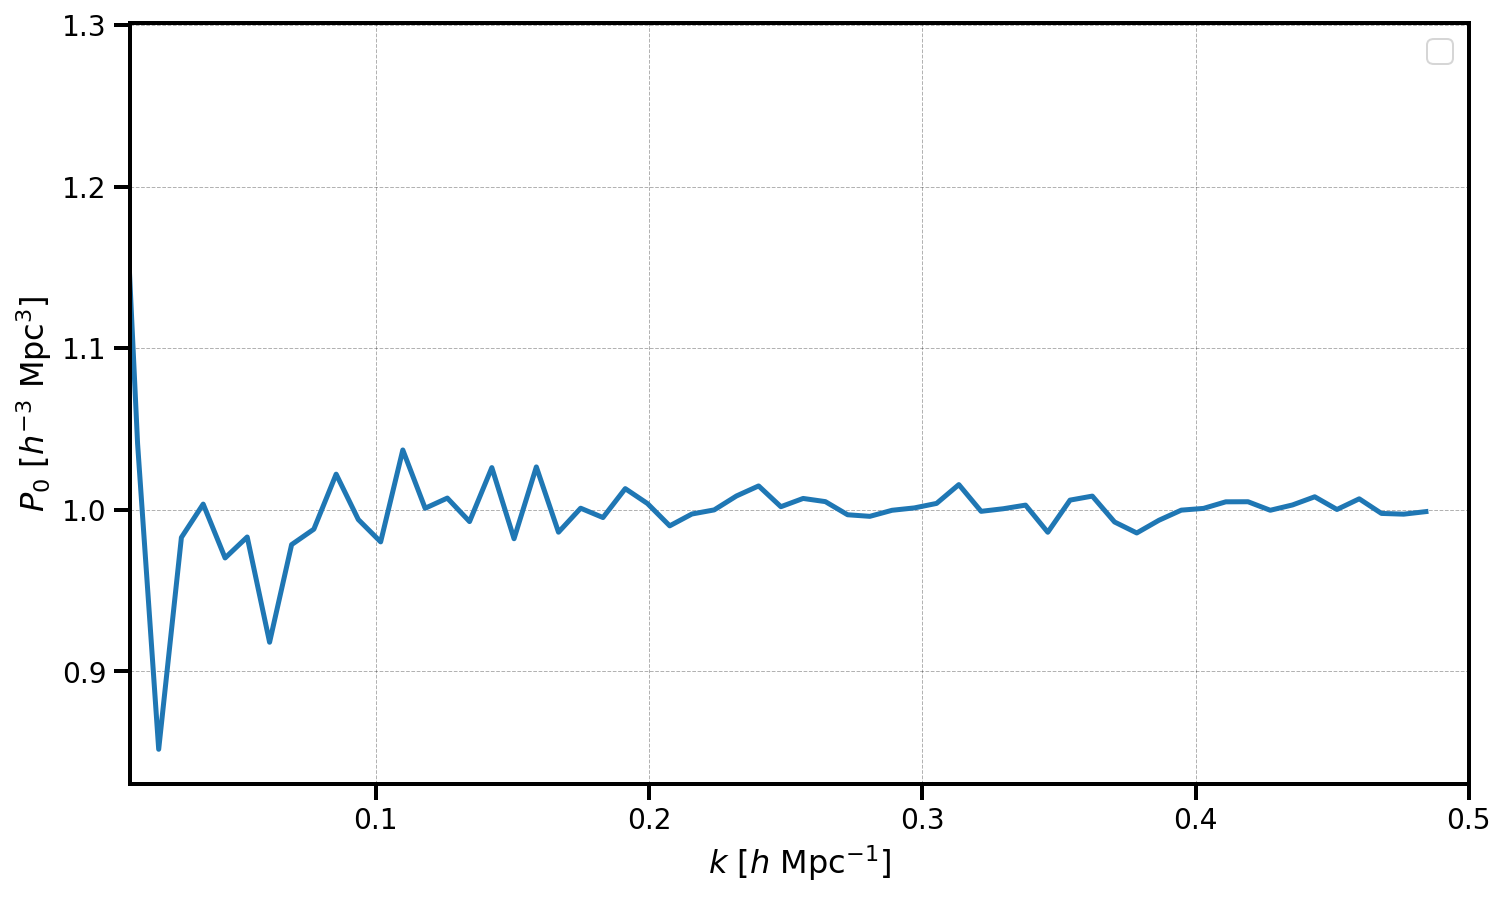

In [49]:
poles = r.poles

plt.plot(poles['k'], 0.5 * poles['power_0'].real * r.attrs['data.norm'] / I12_r) 

plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$ P_0$ [$h^{-3} \ \mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.5)

### BOSS, Patchy, and nseries

In [129]:
nbar = 4.e-4

In [148]:
def get_Psn(I12_d, I12_r, I22_d, I22_r, alpha, beta): 
    if np.abs(1-I12_d/I12_r) < 1e-2: pass
    else: raise Exception('I12 data and randoms not matching! data/randoms = %.3f' % np.abs(1-I12_d/I12_r))
    if np.abs(1-I22_d/I22_r) < 1e-2: pass
    else: raise Exception('I22 data and randoms not matching! data/randoms = %.3f' % np.abs(1-I22_d/I22_r))
    return (I12_d + alpha * I12_r) / (beta * I22_r)

def get_Bsn(I13_d, I13_r, I33_d, I33_r, alpha, beta): 
    if np.abs(1-I13_d/I13_r) < 2e-2: pass
    else: raise Exception('I13 data and randoms not matching! data/randoms = %.3f' % np.abs(1-I13_d/I13_r))
    if np.abs(1-I33_d/I33_r) < 1e-2: pass
    else: raise Exception('I33 data and randoms not matching! data/randoms = %.3f' % np.abs(1-I33_d/I33_r))
    return (I13_d - alpha**2 * I13_r) / (beta**2 * I33_r)

In [149]:
for which in ['nseries', 'patchy', 'boss']:
    for red in ['cmass', 'lowz']:
        for sky in ['ngc', 'sgc']: 
            
            noprint = False
            if which == 'nseries': 
                beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.979, 1.98754e-02, 4.55870e+00, 4.54458e+00, 1.89456e-04, 1.89057e-04, 2.40176e+04, 2.38269e+04, 6.55609e+03, 6.49019e+03
                if red != 'cmass' or sky != 'ngc': noprint = True
            if which == 'patchy': 
                if red == 'cmass':
                    if sky == 'ngc': 
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.875, 2.00279e-02, 1.18448e+01, 1.18448e+01, 8.43224e-04, 8.43172e-04, 5.41841e+04, 5.42105e+04, 2.00586e+04, 2.00796e+04
                    elif sky == 'sgc':
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.805, 1.96234e-02, 4.28737e+00, 4.28666e+00, 3.04232e-04, 3.04155e-04, 1.97502e+04, 1.97441e+04, 7.29967e+03, 7.29295e+03
                elif red == 'lowz':
                    if sky == 'ngc': 
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.889, 2.00751e-02, 4.96317e+00, 4.96076e+00, 3.70766e-04, 3.70677e-04, 1.69764e+04, 1.69516e+04, 4.42127e+03, 4.41169e+03
                    elif sky == 'sgc':
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.883, 2.04666e-02, 1.96625e+00, 1.96701e+00, 1.47065e-04, 1.47082e-04, 6.69224e+03, 6.70271e+03, 1.73628e+03, 1.74081e+03
            if which == 'boss': 
                if red == 'cmass':
                    if sky == 'ngc': 
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.929, 2.05256e-02, 1.17267e+01, 1.17286e+01, 8.36394e-04, 8.36369e-04, 5.31809e+04, 5.32210e+04, 1.95532e+04, 1.95724e+04
                    elif sky == 'sgc':
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.929, 2.12161e-02, 4.34438e+00, 4.34443e+00, 3.09346e-04, 3.09348e-04, 1.97447e+04, 1.97455e+04, 7.23546e+03, 7.23595e+03
                elif red == 'lowz':
                    if sky == 'ngc': 
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.925, 2.05963e-02, 5.02191e+00, 5.02252e+00, 3.70544e-04, 3.70519e-04, 1.81891e+04, 1.82094e+04, 5.02433e+03, 5.03608e+03
                    elif sky == 'sgc':
                        beta, alpha, I22_d, I22_r, I33_d, I33_r, I12_d, I12_r, I13_d, I13_r = 0.922, 2.11983e-02, 2.02006e+00, 2.02008e+00, 1.54910e-04, 1.54910e-04, 6.19886e+03, 6.19928e+03, 1.48930e+03, 1.48948e+03

            Psn = get_Psn(I12_d, I12_r, I22_d, I22_r, alpha, beta) 
            Bsn = get_Bsn(I13_d, I13_r, I33_d, I33_r, alpha, beta) 
            
            if not noprint: print ('%s %s %s: Psn = %.3e, Bsn = %.3e, Psn^2/Bsn = %.2f, Psn nbar = %.3f, Bsn nbar^2 = %.3f' % 
                   (which, red, sky, Psn, Bsn, Psn**2/Bsn, Psn * nbar, Bsn * nbar**2))
            
            

nseries cmass ngc: Psn = 5.505e+03, Bsn = 3.617e+07, Psn^2/Bsn = 0.84, Psn nbar = 2.202, Bsn nbar^2 = 5.787
patchy cmass ngc: Psn = 5.333e+03, Bsn = 3.106e+07, Psn^2/Bsn = 0.92, Psn nbar = 2.133, Bsn nbar^2 = 4.970
patchy cmass sgc: Psn = 5.836e+03, Bsn = 3.702e+07, Psn^2/Bsn = 0.92, Psn nbar = 2.334, Bsn nbar^2 = 5.923
patchy lowz ngc: Psn = 3.927e+03, Bsn = 1.509e+07, Psn^2/Bsn = 1.02, Psn nbar = 1.571, Bsn nbar^2 = 2.414
patchy lowz sgc: Psn = 3.932e+03, Bsn = 1.513e+07, Psn^2/Bsn = 1.02, Psn nbar = 1.573, Bsn nbar^2 = 2.421
boss cmass ngc: Psn = 4.981e+03, Bsn = 2.708e+07, Psn^2/Bsn = 0.92, Psn nbar = 1.992, Bsn nbar^2 = 4.332
boss cmass sgc: Psn = 4.996e+03, Bsn = 2.709e+07, Psn^2/Bsn = 0.92, Psn nbar = 1.998, Bsn nbar^2 = 4.334
boss lowz ngc: Psn = 3.996e+03, Bsn = 1.584e+07, Psn^2/Bsn = 1.01, Psn nbar = 1.598, Bsn nbar^2 = 2.535
boss lowz sgc: Psn = 3.399e+03, Bsn = 1.130e+07, Psn^2/Bsn = 1.02, Psn nbar = 1.360, Bsn nbar^2 = 1.809
